# Validation of Meta canopy height over Barro Colorado Island, Panama

This is a notebook for validating Meta canopy heights in R using airborne lidar data.



***

### The first steps in this notebook are about preparing your workspace and loading the airborne lidar data



### **1.** This notebook is designed to run on the NASA MAAP in a "MAAP R Stable" workspace. 
To prepare your workspace, install packages via the terminal and restart the kernel in this notebook by either:

&emsp;**a.** Install from configuration file (this is much faster):

&emsp;&emsp;`conda env update -f /projects/shared-buckets/minord/biomass_reference_maps/env/biomass-reference-env.yml --prune`

&emsp;&emsp;`conda env create -f /projects/shared-buckets/minord/biomass_reference_maps/env/greta-env.yml`

&emsp;**b.** Install from scratch (may take 2+ hours)

&emsp;&emsp;`conda install -c conda-forge r-lidr r-future r-viridis r-greta r-igraph r-bayesplot`

&emsp;&emsp;`conda install -c r r-leaflet r-diagrammer`

&emsp;&emsp;`conda create -n greta-env python=3.7`

&emsp;&emsp;`conda activate greta-env`

&emsp;&emsp;`conda install -c conda-forge numpy=1.16.4 tensorflow=1.14.0 tensorflow-probability=0.7.0`


### **2.** Load the necessary packages in R

In [1]:
# Load relevant packages
#install.packages('bayesplot')
#install.packages('greta')

# ALS processing 
suppressWarnings(suppressMessages(library(lidR)))
suppressWarnings(suppressMessages(library(sf)))
suppressWarnings(suppressMessages(library(future)))
suppressWarnings(suppressMessages(library(terra)))

# Plotting
suppressWarnings(suppressMessages(library(viridis)))
suppressWarnings(suppressMessages(library(leaflet)))
suppressWarnings(suppressMessages(library(ggplot2)))

# Bayesian modeling
suppressWarnings(suppressMessages(library(greta)))
suppressWarnings(suppressMessages(library(bayesplot)))




***

### **3.** Set paths to ALS and field data. Read in ALS catalog.

In [2]:
als_path <- '/projects/shared-buckets/minord/data/panama_bci/ALS_ground'
norm_path <- paste0(als_path, "/outputs/norm")

ctg_norm <- readLAScatalog(norm_path)
opt_progress(ctg_norm) <- FALSE

  |======================================================================| 100%

In [3]:
ext(ctg_norm)

SpatExtent : 623169.27, 630506.91, 1008579.52, 1015698.37 (xmin, xmax, ymin, ymax)

In [4]:
meta_chm <-rast("/projects/shared-buckets/alexdevseed/geotrees/meta_chm_032221130_cog.tif")

In [5]:
ext(meta_chm)

SpatExtent : -8922952.93389834, -8844681.41693431, 1017529.72053227, 1095801.23749629 (xmin, xmax, ymin, ymax)

In [6]:
crs(meta_chm)

[1] "PROJCRS[\"WGS 84 / Pseudo-Mercator\",\n    BASEGEOGCRS[\"WGS 84\",\n        DATUM[\"World Geodetic System 1984\",\n            ELLIPSOID[\"WGS 84\",6378137,298.257223563,\n                LENGTHUNIT[\"metre\",1]]],\n        PRIMEM[\"Greenwich\",0,\n            ANGLEUNIT[\"degree\",0.0174532925199433]],\n        ID[\"EPSG\",4326]],\n    CONVERSION[\"unnamed\",\n        METHOD[\"Popular Visualisation Pseudo Mercator\",\n            ID[\"EPSG\",1024]],\n        PARAMETER[\"Latitude of natural origin\",0,\n            ANGLEUNIT[\"degree\",0.0174532925199433],\n            ID[\"EPSG\",8801]],\n        PARAMETER[\"Longitude of natural origin\",0,\n            ANGLEUNIT[\"degree\",0.0174532925199433],\n            ID[\"EPSG\",8802]],\n        PARAMETER[\"False easting\",0,\n            LENGTHUNIT[\"metre\",1],\n            ID[\"EPSG\",8806]],\n        PARAMETER[\"False northing\",0,\n            LENGTHUNIT[\"metre\",1],\n            ID[\"EPSG\",8807]]],\n    CS[Cartesian,2],\n        AXIS[\"easting (X)\",east,\n            ORDER[1],\n            LENGTHUNIT[\"metre\",1]],\n        AXIS[\"northing (Y)\",north,\n            ORDER[2],\n            LENGTHUNIT[\"metre\",1]],\n    USAGE[\n        SCOPE[\"Web mapping and visualisation.\"],\n        AREA[\"World between 85.06°S and 85.06°N.\"],\n        BBOX[-85.06,-180,85.06,180]],\n    ID[\"EPSG\",3857]]"

In [7]:
crs(ctg_norm)

Coordinate Reference System:
Deprecated Proj.4 representation:
 +proj=utm +zone=17 +datum=WGS84 +units=m +no_defs 
WKT2 2019 representation:
PROJCRS["WGS 84 / WGS 84 / UTM 17N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 17N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-81,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGT

In [8]:
# Crop Meta tile to ALS extent, and convert projection to UTM
als_ext <- terra::project(ext(ctg_norm), from='EPSG:32617', to='EPSG:3857')

meta_chm_cropped <- crop(meta_chm, als_ext)

als_crs <- crs(ctg_norm)
meta_chm_utm <- project(x=meta_chm_cropped, y='EPSG:32617')

In [9]:
res(meta_chm_utm)

[1] 1.175229 1.175229


***

### **4.** Create and display a Canopy Height Model.
#### The CHM is produced from 2023 airborne lidar at the same resolution as the Meta product (1.18 m)

In [10]:
overwrite=FALSE

In [11]:
#Create the canopy height model
ctg_norm@output_options$drivers$SpatRaster$param$overwrite <- TRUE

opt_chunk_size(ctg_norm) <- 400
opt_chunk_buffer(ctg_norm) <- 40
future::plan(multicore, workers = 8)
#opt_restart(ctg_norm) <- 224

chm_path <- paste0(als_path, "/outputs/chm_at_meta_res")
opt_output_files(ctg_norm)<- paste0(chm_path, "/chm_chunk_{XCENTER}_{YCENTER}")

opt_stop_early(ctg_norm) <- FALSE



if(overwrite){
    als_chm <- rasterize_canopy(ctg_norm, res = meta_chm_utm, pitfree(thresholds = c(0, 10, 20), max_edge = c(0, 1.5)))
} else{
    als_chm <- terra::vrt(paste0(chm_path, "/rasterize_canopy.vrt"))
} 

In [12]:
#Crop to make sure the extents match, and mask out water.
meta_cropped <- crop(meta_chm_utm, als_chm)

water_mask <- ifel(meta_cropped == 0, NA, 1)

als_chm_masked <- mask(als_chm, water_mask)
meta_chm_masked <- mask(meta_cropped, water_mask)

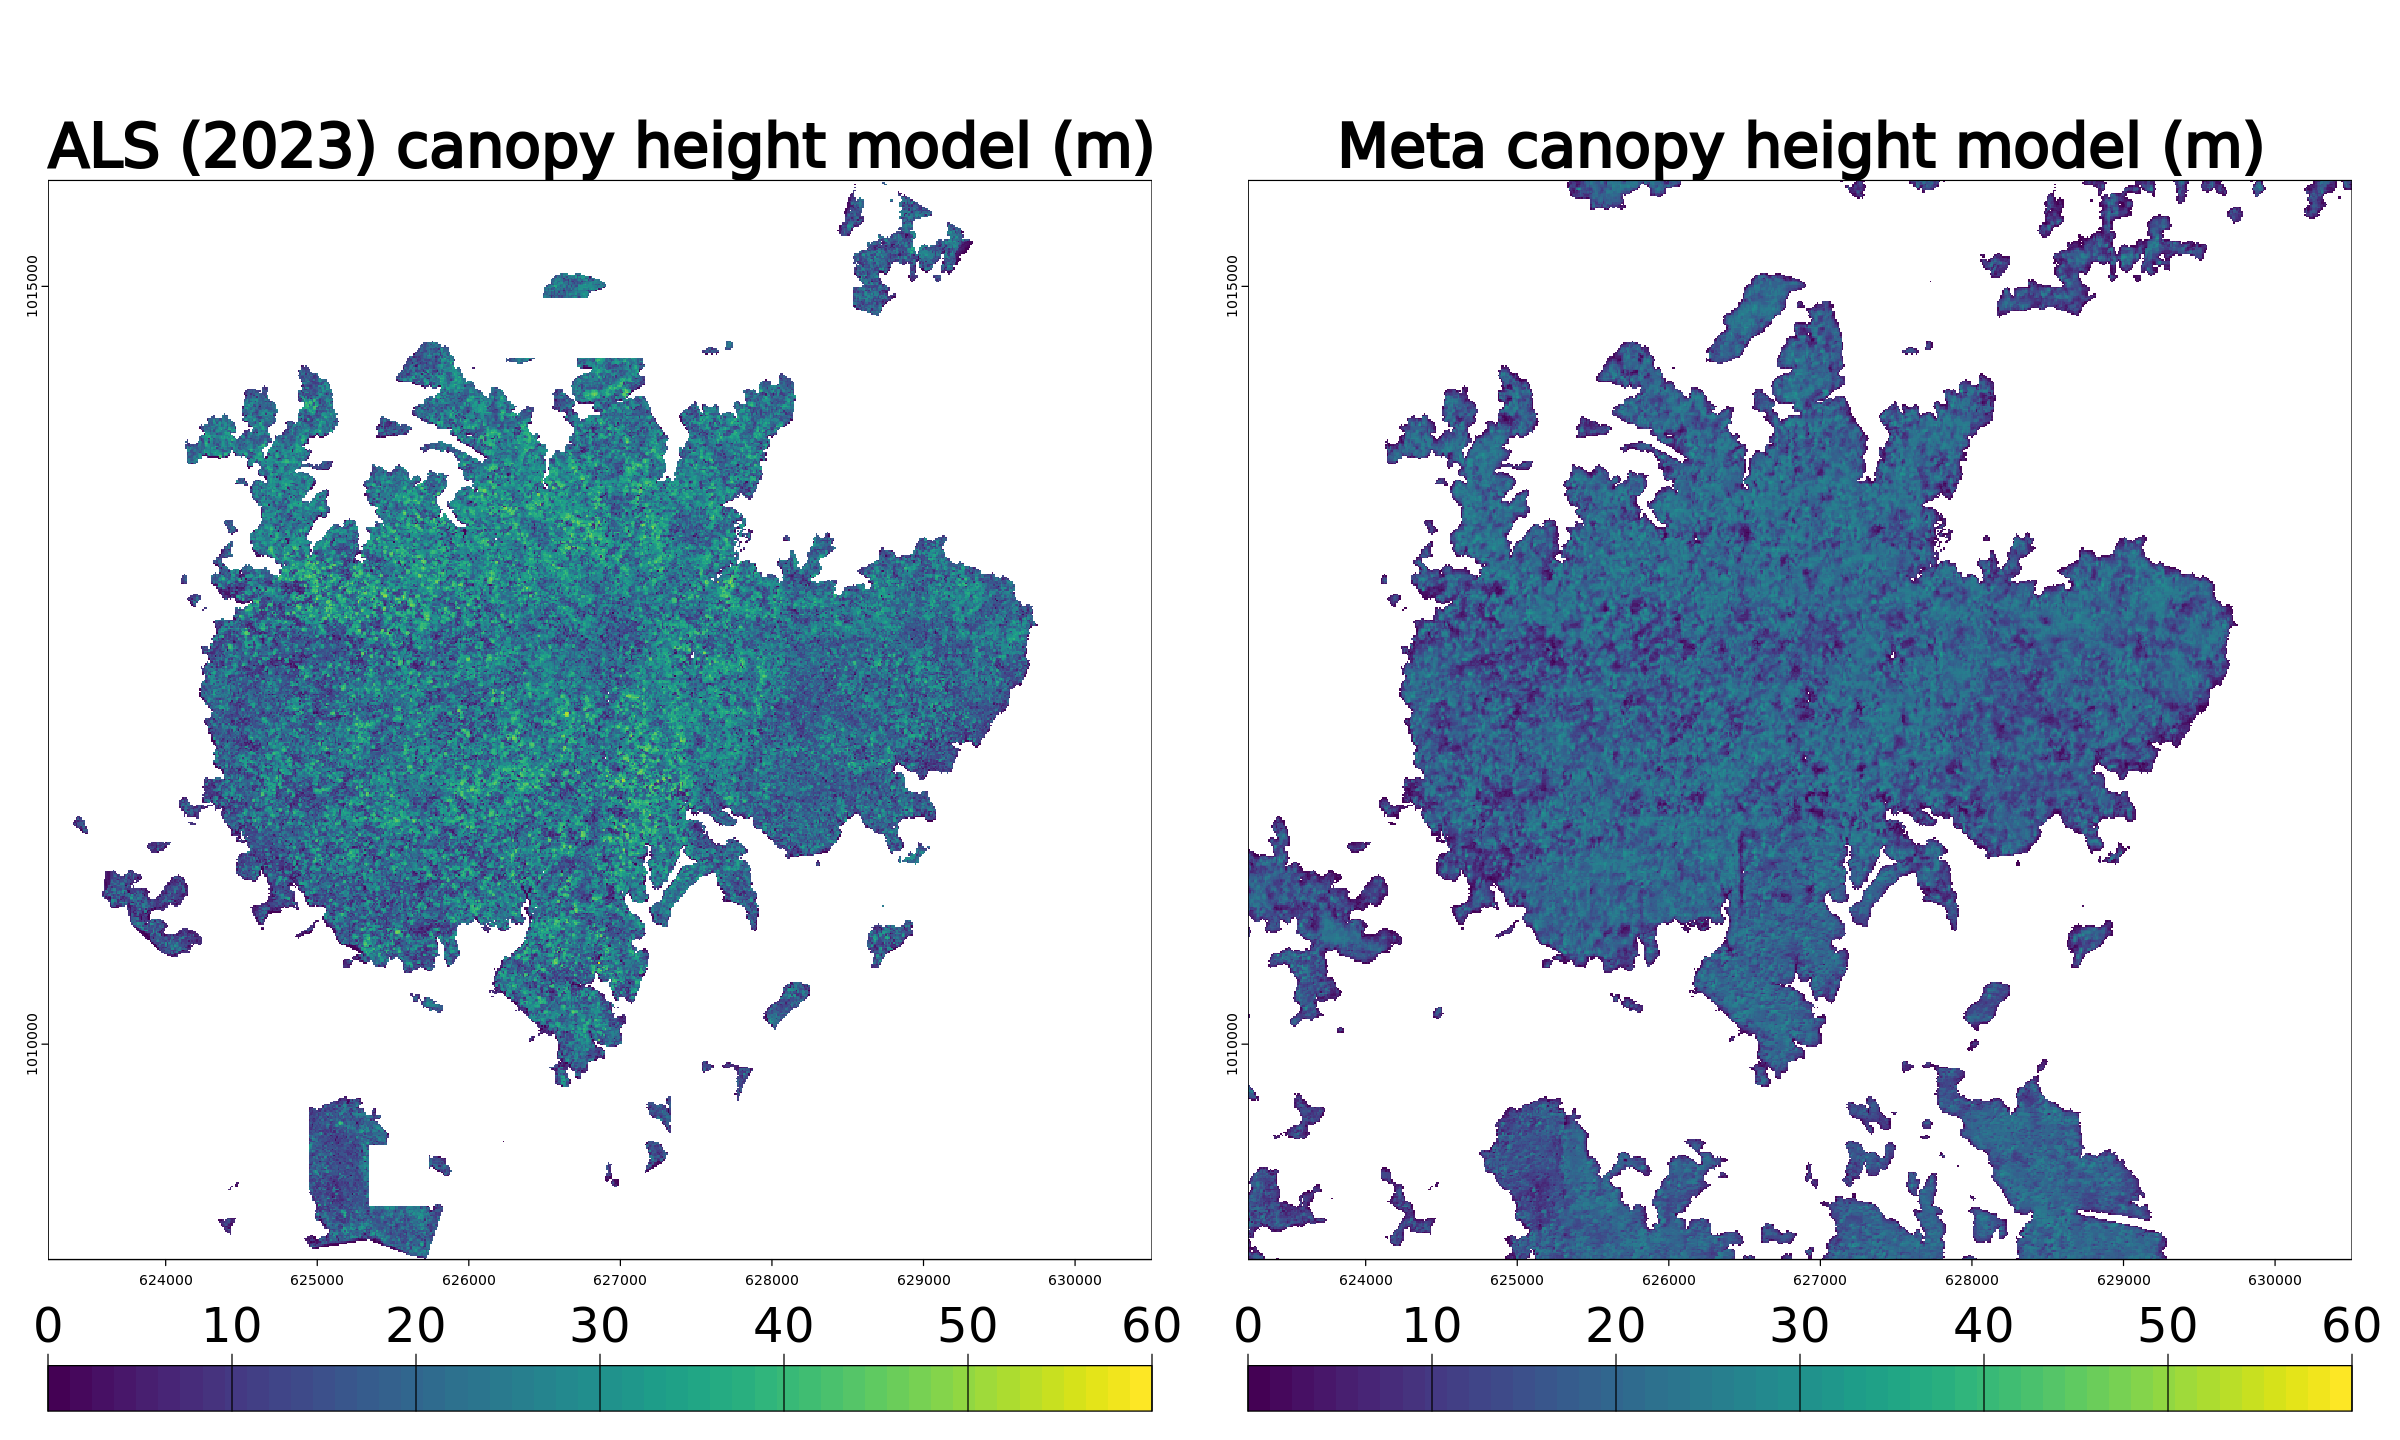

In [13]:
# CHM on a fixed map
options(repr.plot.width=20, repr.plot.height=12)
par(mfrow=c(1,2))

e <- ext(als_chm)
leg.e <- c(e[1:2], e[3]-1000, e[3]-700)

zlim <- c(0,60)

plot(als_chm_masked, col=viridis(50), main="ALS (2023) canopy height model (m)",
         cex.main=3, plg=list(loc='top', ext=leg.e, cex=3),range=zlim)

plot(meta_chm_masked, col = viridis(50), main="Meta canopy height model (m)", 
     cex.main=3, plg=list(loc='top', ext=leg.e, cex=3), range=zlim)

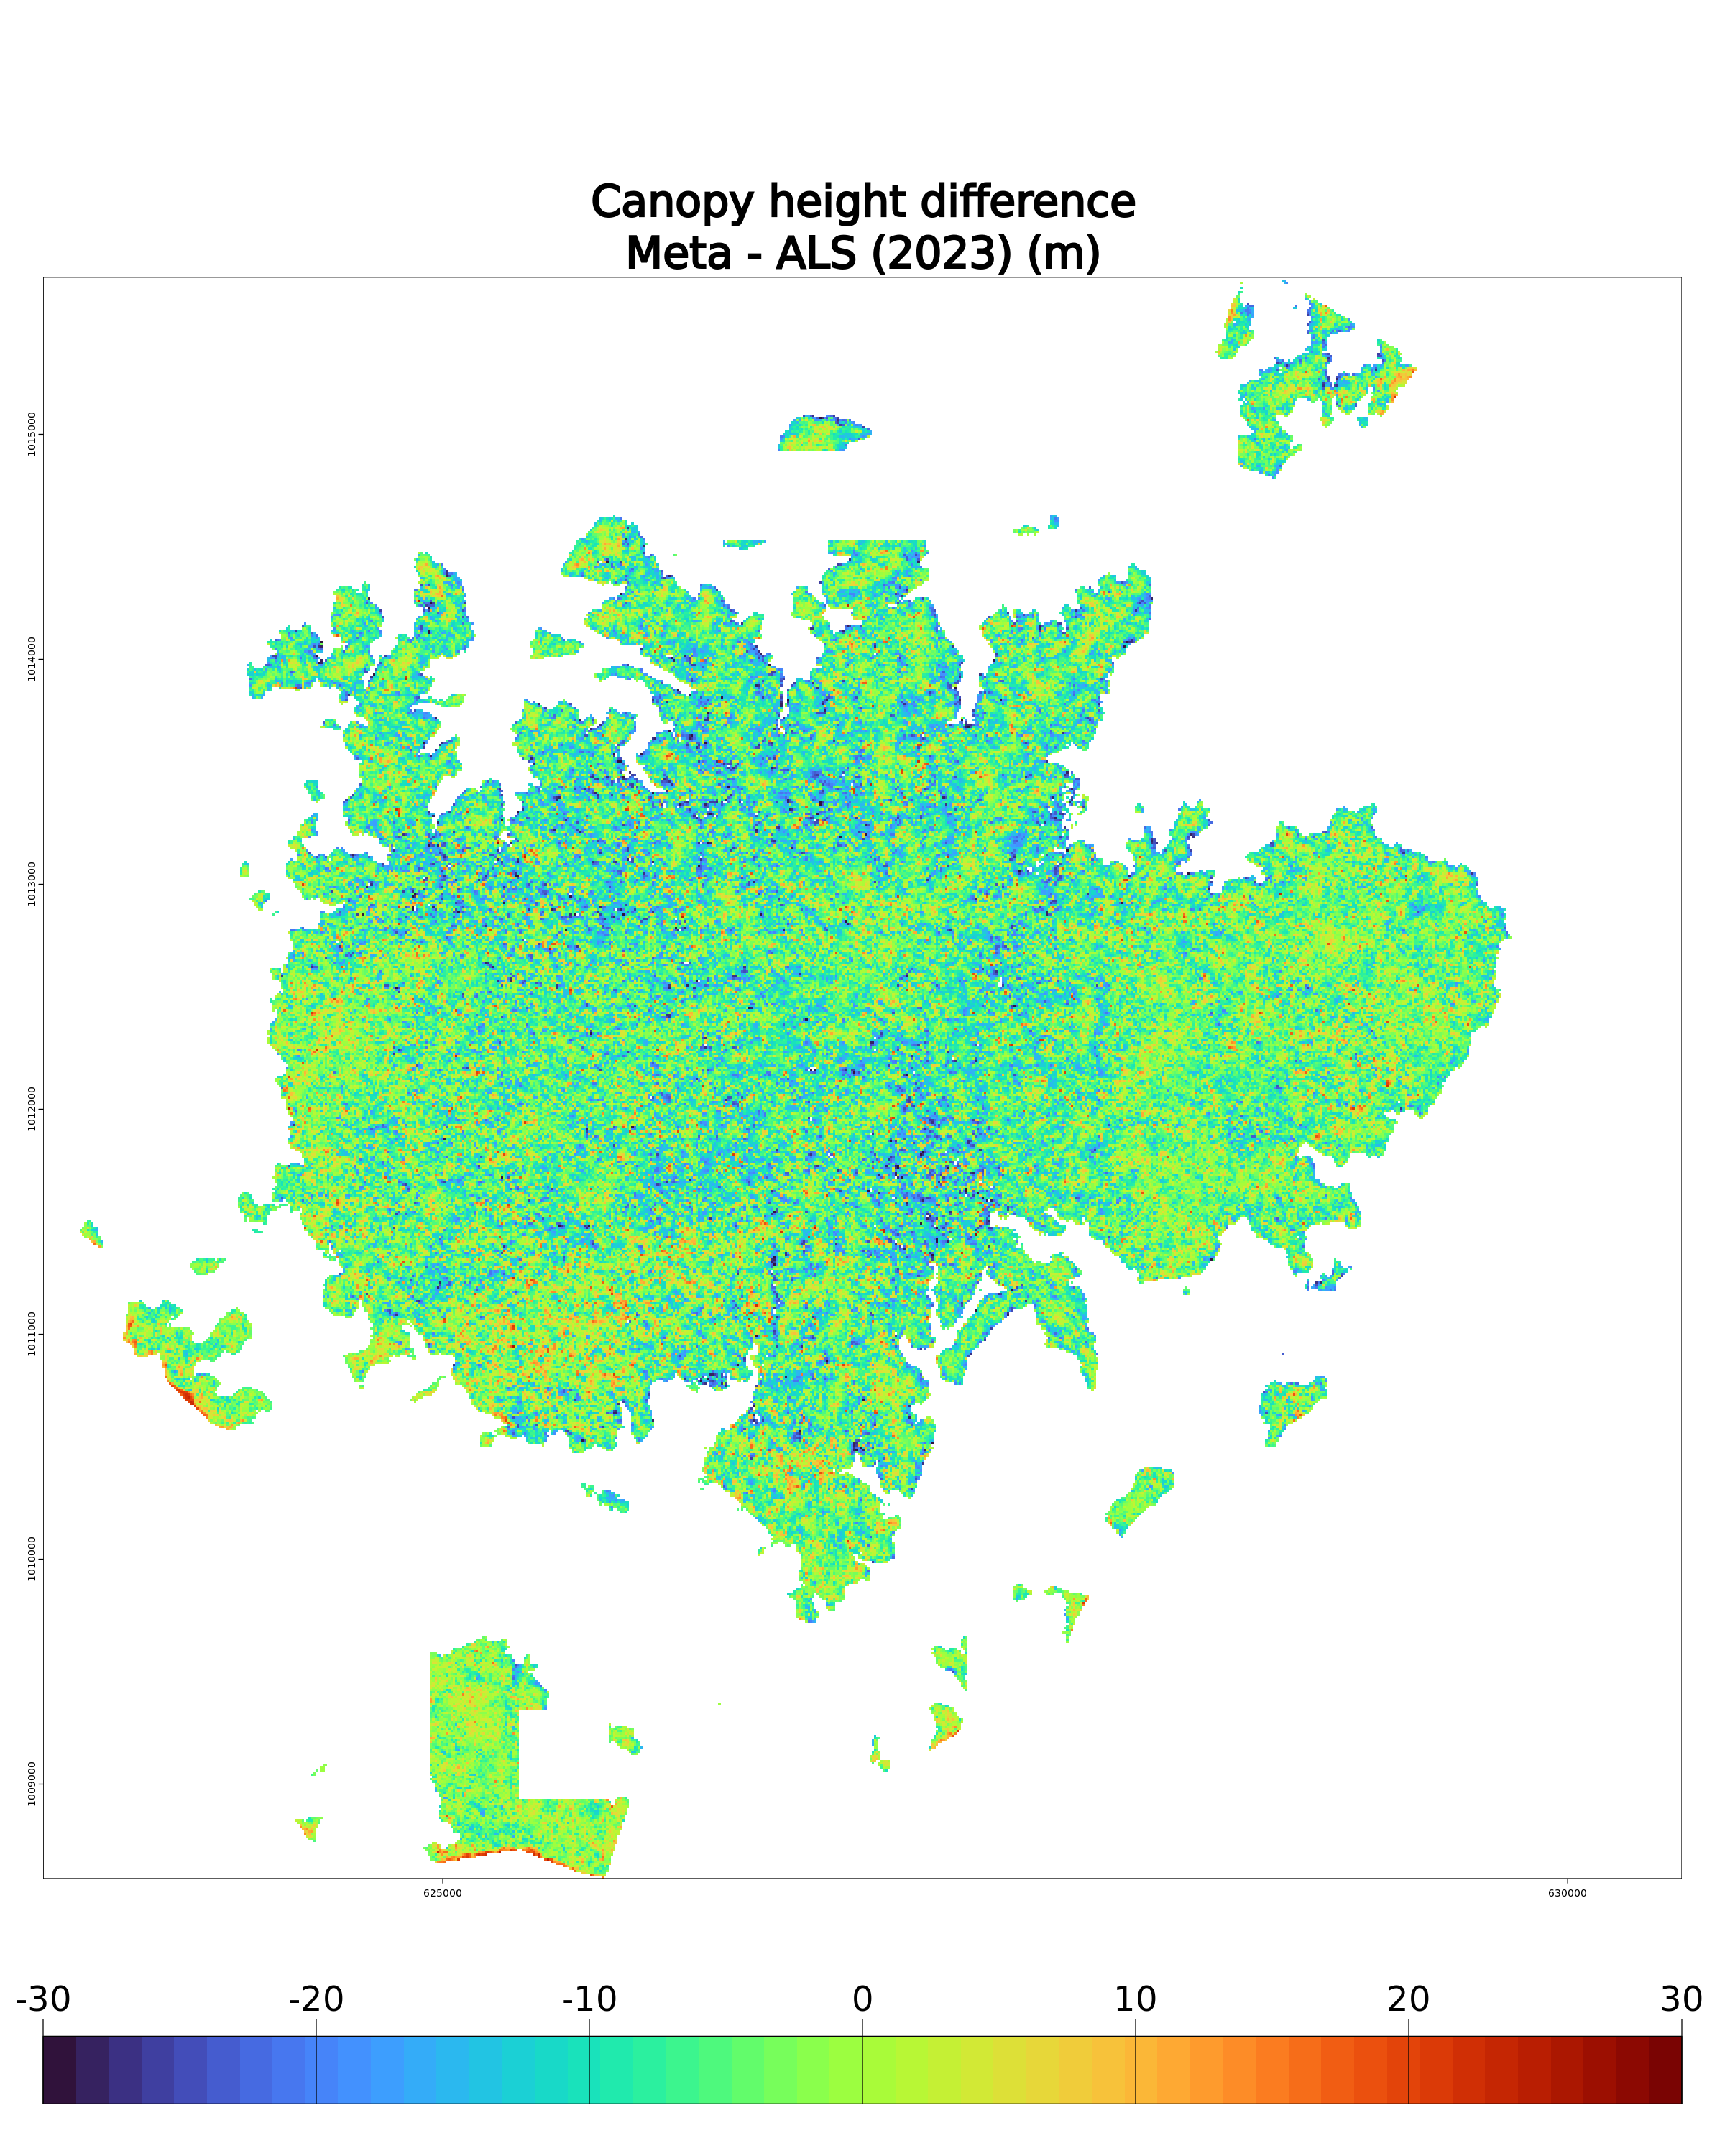

In [14]:
# CHM difference on a fixed map

chm_diff <- meta_chm_masked - als_chm_masked 
rmse <- sqrt(mean((values(meta_chm_masked)-values(als_chm_masked))^2,na.rm=T))
bias <- mean(values(meta_chm_masked)-values(als_chm_masked),na.rm=T)

options(repr.plot.width=20, repr.plot.height=25)
par(oma = c(10, 0.5, 10, 0.5), mar= c(10, 4, 10, 2))

e <- ext(chm_diff)
leg.e <- c(e[1:2], e[3]-1000, e[3]-700)

zlim <- c(-30,30)

plot(chm_diff, col=turbo(50), main="Canopy height difference\nMeta - ALS (2023) (m)",
         cex.main=3, plg=list(loc='top', ext=leg.e, cex=3),range=zlim)



In [15]:

f <- paste0(als_path, "/outputs/meta_als_chm_diff.tif")
writeRaster(chm_diff, f, overwrite=overwrite, filetype="COG")

ERROR: Error: [writeRaster] file exists. You can use 'overwrite=TRUE' to overwrite it


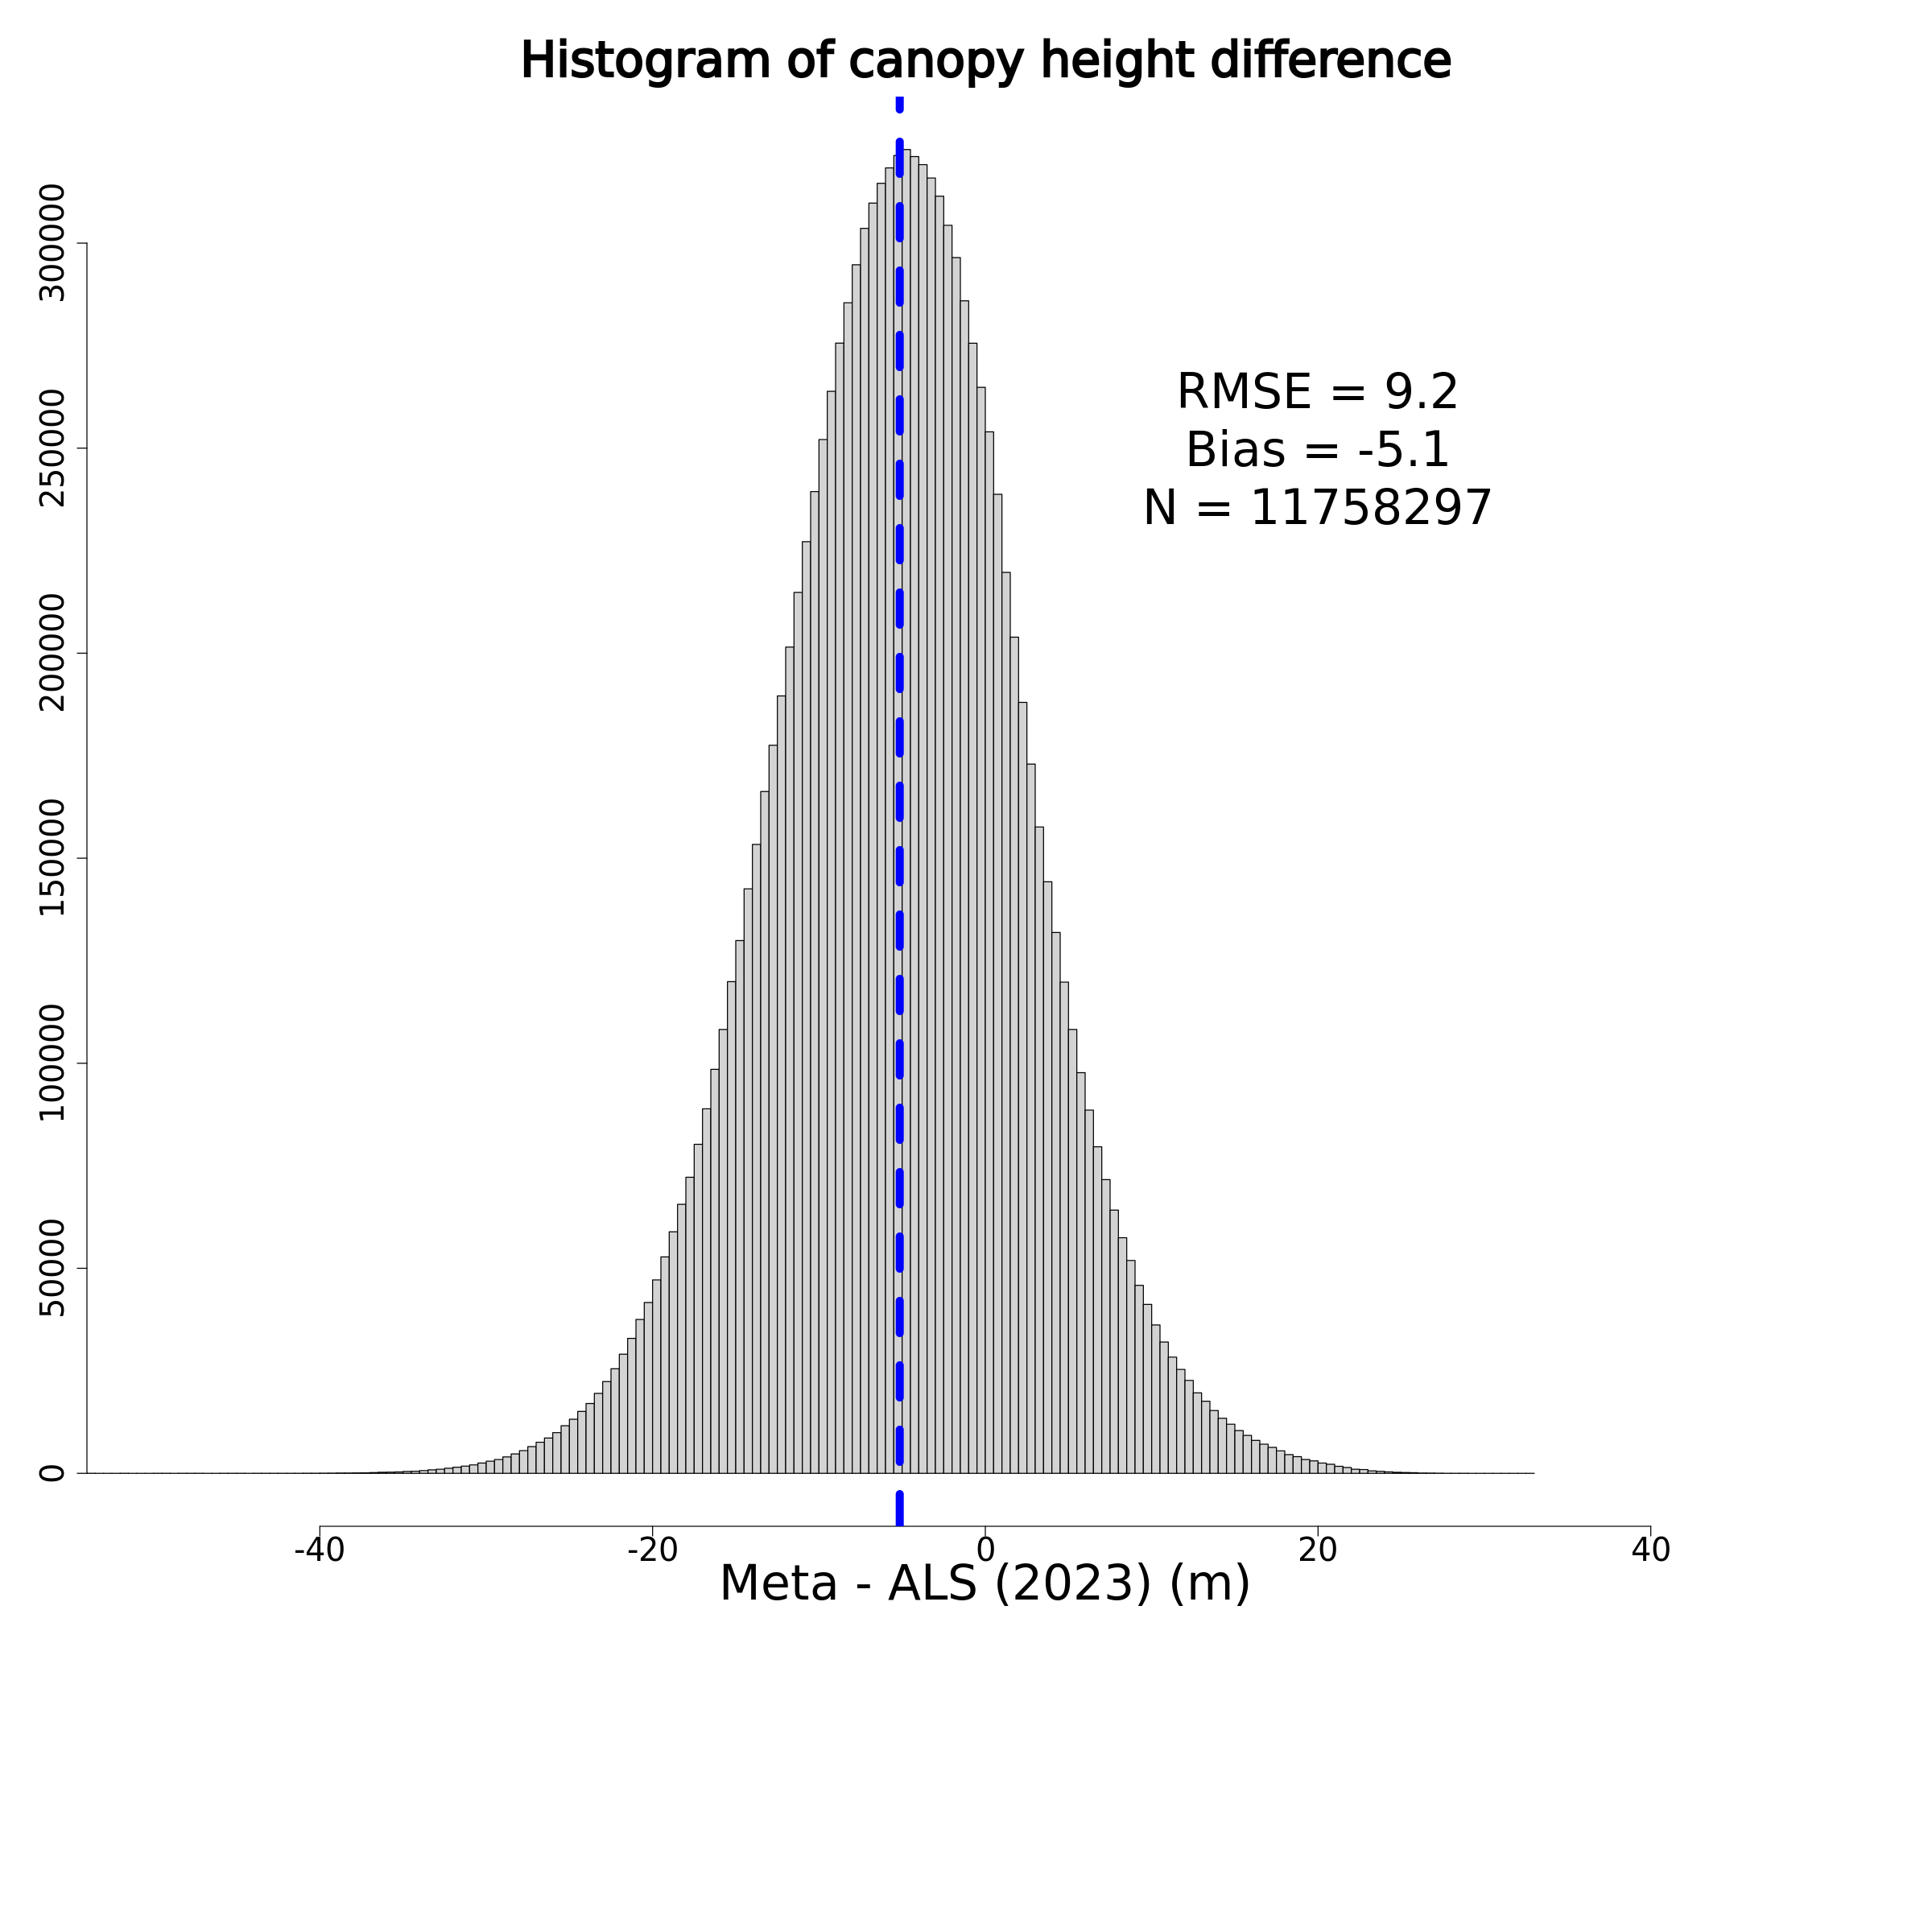

In [16]:
options(repr.plot.width=20, repr.plot.height=20)
par(oma = c(1, 0.5, 1, 0.5), mar= c(20, 4, 4, 2))

chm_diff_values <- values(chm_diff)
n <- sum(!is.na(chm_diff_values))

hist(chm_diff_values, main=paste0("Histogram of canopy height difference"),
        cex.main=3, xlab = "Meta - ALS (2023) (m)", cex.lab=3, cex.axis=2, breaks=500, 
         xlim=c(-50,50),ylab="", mar= c(2000, 4, 4, 2))
abline(v = bias, lty=2, lwd=8, col='blue')
text(x=20, y=250000, paste0("RMSE = ", round(rmse,1), "\nBias = ", round(bias,1), "\nN = ",n), cex=3)

Warning message:
“Removed 25789187 rows containing non-finite values (`stat_binhex()`).”
Warning message:
“Removed 37 rows containing missing values (`geom_hex()`).”


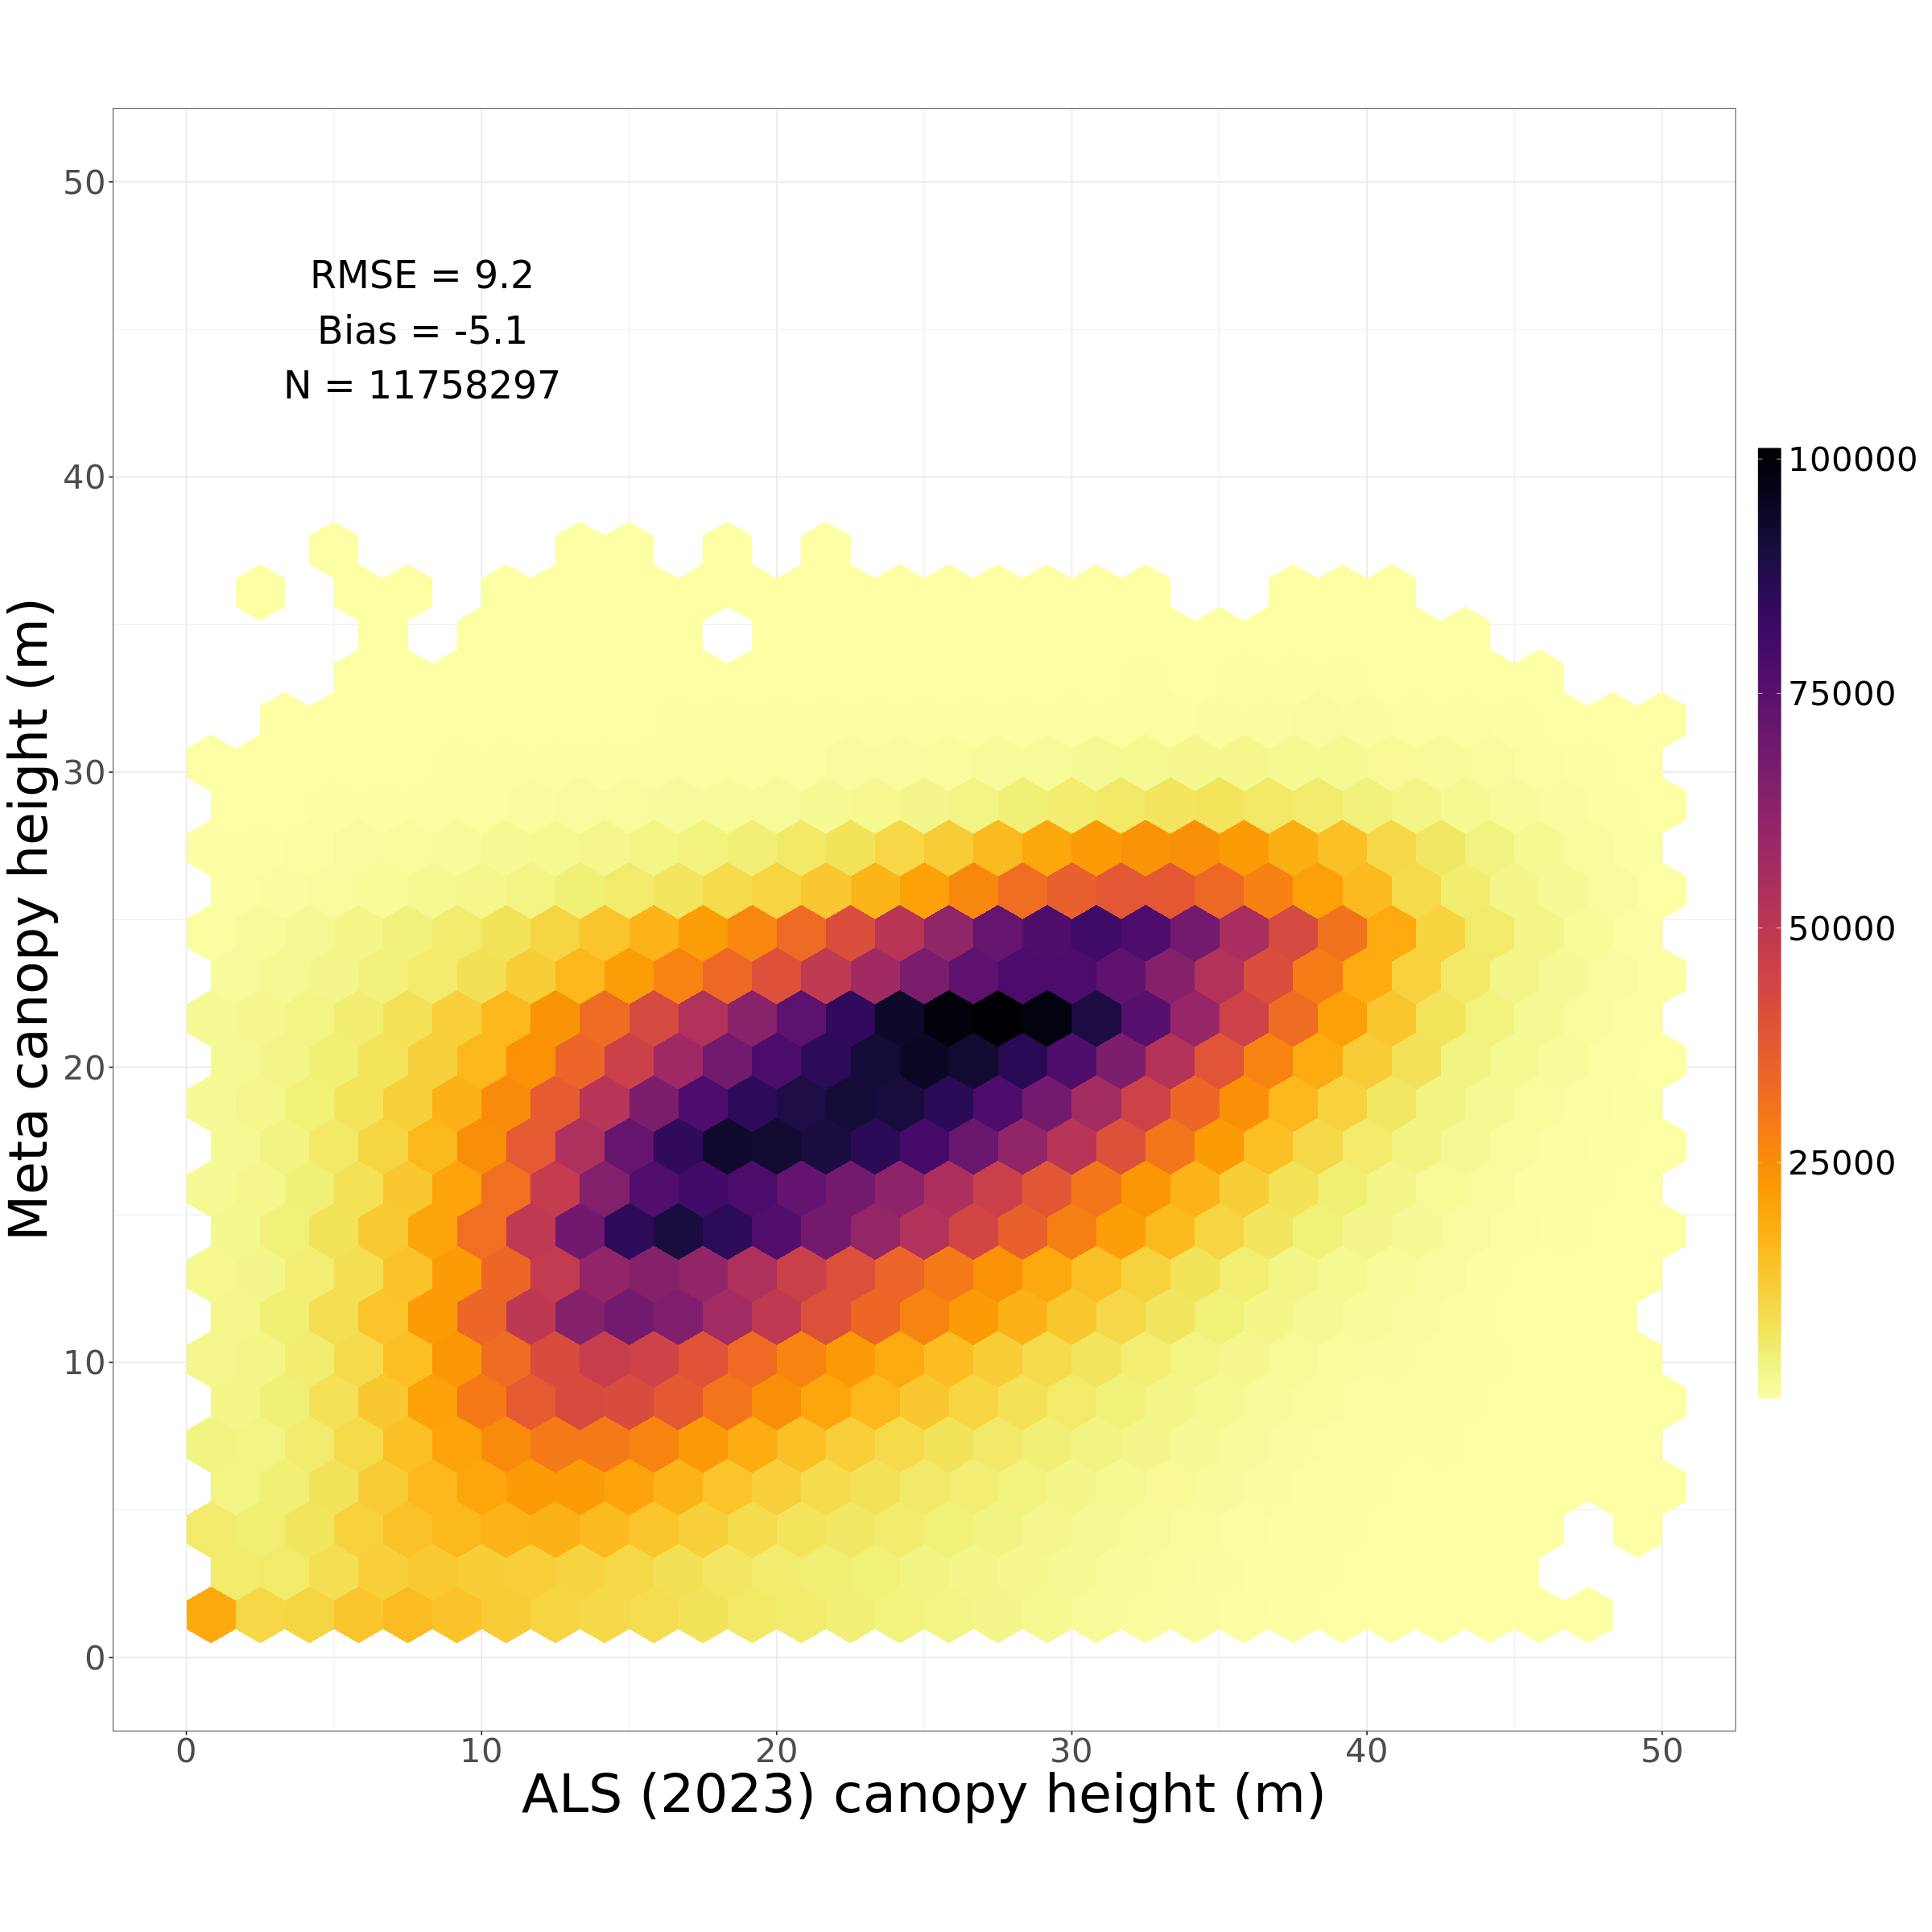

In [17]:
options(repr.plot.width=20, repr.plot.height=20)
par(cex.lab=2)

# Create data
x <- values(als_chm_masked)
y <- values(meta_chm_masked)


y <- y[x<50]
x <- x[x<50]

dat <- data.frame(x = x, y = y)

ggplot(dat, aes(x = x, y = y)) +
  geom_hex() + coord_fixed() +
  scale_fill_gradientn(colours = rev(inferno(256))) +
  xlim(0, 50) + ylim(0,50) +
  labs(x = "ALS (2023) canopy height (m)", y="Meta canopy height (m)") +
  annotate("text", size=10, x=8, y=45, label= paste0("RMSE = ", round(rmse,1), "\nBias = ", round(bias,1), "\nN = ",n)) +
  theme_bw() + 
  theme(aspect.ratio=1) +
  theme(axis.text = element_text(size = 25), axis.title = element_text(size = 40), 
        legend.key.height = unit(5, 'cm'), legend.text = element_text(size=25),
       legend.title=element_blank())